In [ ]:
!pip install pandas scikit-learn matplotlib seaborn geopandas

In [48]:
# --- Import library ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from google.colab import files
uploaded = files.upload()  # Upload file kabupaten_bengkulu_penggunaan_lahan.csv


Saving data_non_spasial_banjir_bengkulu_kabupaten.csv to data_non_spasial_banjir_bengkulu_kabupaten (4).csv
Saving penggunaan_lahan_provinsi_bengkulu.csv to penggunaan_lahan_provinsi_bengkulu.csv


In [49]:
df = pd.read_csv("penggunaan_lahan_provinsi_bengkulu.csv")
print("Kolom tersedia:", df.columns)

import numpy as np
np.random.seed(42)
df["Pernah Banjir"] = np.random.choice([0, 1], size=len(df))


Kolom tersedia: Index(['Kabupaten/Kota', 'Lahan Sawah (ha)', 'Lahan Permukiman (ha)',
       'Lahan Perkebunan (ha)', 'Lahan Hutan (ha)', 'Lahan Terbuka (ha)',
       'Total Luas Penggunaan Lahan (ha)'],
      dtype='object')


In [50]:
X = df[['Lahan Sawah (ha)', 'Lahan Permukiman (ha)', 'Lahan Perkebunan (ha)',
        'Lahan Hutan (ha)', 'Lahan Terbuka (ha)']]
y = df['Pernah Banjir']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# --- Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [67]:
threshold = 0.3  # contoh threshold lebih rendah dari 0.5
y_pred_custom = (y_proba >= threshold).astype(int)

print(f"\nEvaluasi dengan threshold {threshold}:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred_custom):.3f}")
print(f"Precision : {precision_score(y_test, y_pred_custom, zero_division=0):.3f}")
print(f"Recall    : {recall_score(y_test, y_pred_custom):.3f}")
print(f"F1 Score  : {f1_score(y_test, y_pred_custom):.3f}")
print(f"ROC AUC   : {roc_auc_score(y_test, y_proba):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom, zero_division=0))



Evaluasi dengan threshold 0.3:
Accuracy  : 0.500
Precision : 0.000
Recall    : 0.000
F1 Score  : 0.000
ROC AUC   : 0.000

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



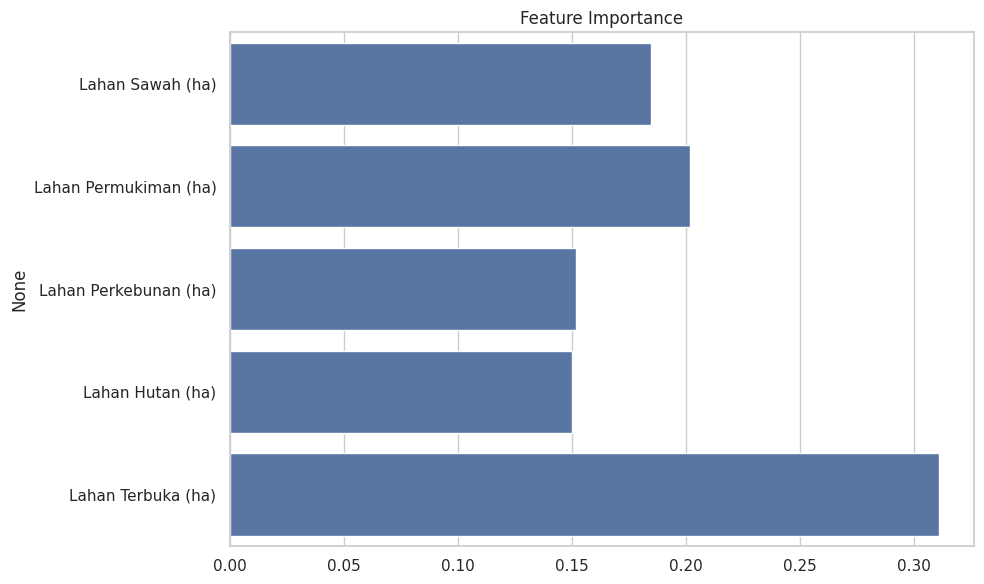

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
importances = model.feature_importances_
feat_names = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

df['Prediksi Banjir'] = model.predict(X)

# --- Simpan hasil prediksi ---
output = df[['Kabupaten/Kota', 'Prediksi Banjir']]
output.to_csv("prediksi_banjir_kabupaten_bengkulu.csv", index=False)
files.download("prediksi_banjir_kabupaten_bengkulu.csv")

In [64]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import files

uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

extract_dir = "shapefile_bengkulu"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

def find_shp(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.shp'):
                return os.path.join(root, file)
    return None

shp_path = find_shp(extract_dir)
assert shp_path is not None, "File .shp tidak ditemukan dalam ZIP!"

gdf = gpd.read_file(shp_path)
print("Kolom tersedia dalam shapefile:", gdf.columns)

print("Upload file prediksi_banjir_kabupaten_bengkulu.csv")
uploaded = files.upload()
df_pred = pd.read_csv("prediksi_banjir_kabupaten_bengkulu.csv")
print(df_pred)



Saving [geosai.my.id]Bengkulu_Kab.zip to [geosai.my.id]Bengkulu_Kab (6).zip
Kolom tersedia dalam shapefile: Index(['ADM0_EN', 'date', 'validOn', 'PROVINCE', 'Kabupaten', 'PRV2',
       'geometry'],
      dtype='object')
Upload file prediksi_banjir_kabupaten_bengkulu.csv


Saving prediksi_banjir_kabupaten_bengkulu.csv to prediksi_banjir_kabupaten_bengkulu (4).csv
               Kabupaten/Kota  Prediksi Banjir
0               Kota Bengkulu                0
1  Kabupaten Bengkulu Selatan                0
2   Kabupaten Bengkulu Tengah                0
3    Kabupaten Bengkulu Utara                0
4              Kabupaten Kaur                0
5         Kabupaten Kepahiang                1
6            Kabupaten Lebong                0
7         Kabupaten Muko-Muko                0
8     Kabupaten Rejang Lebong                0
9            Kabupaten Seluma                1


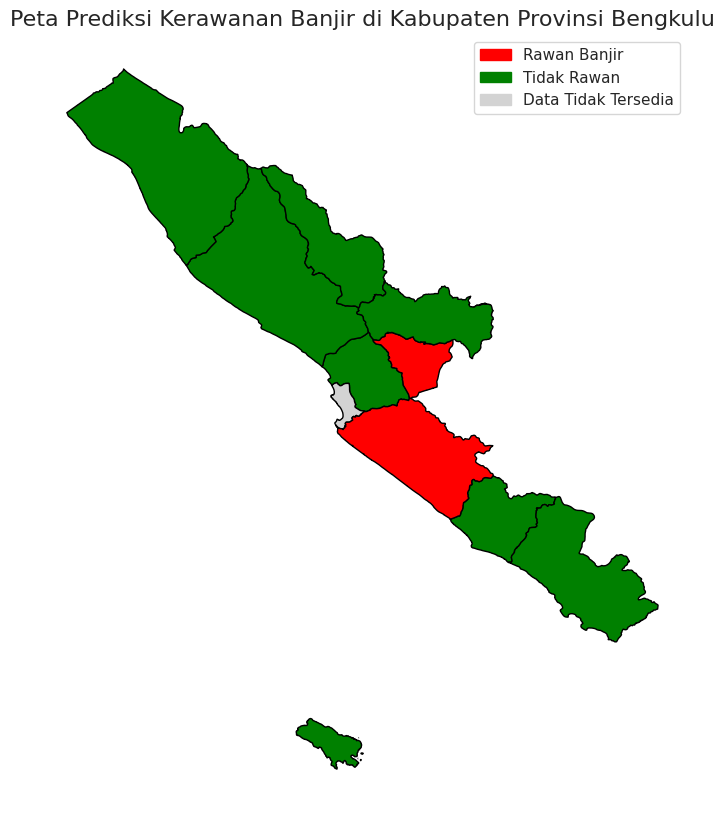

In [65]:
def clean_name(name):
    name = name.lower()
    name = name.replace('kabupaten ', '').replace('kota ', '').strip()
    name = name.replace('muko-muko', 'mukomuko')  # Samakan penulisan
    return name

df_pred['Kabupaten_Clean'] = df_pred['Kabupaten/Kota'].apply(clean_name)

gdf['Kabupaten_Clean'] = gdf['Kabupaten'].str.lower()

gdf_merged = gdf.merge(df_pred, how='left', left_on='Kabupaten_Clean', right_on='Kabupaten_Clean')

gdf_merged['warna'] = gdf_merged['Prediksi Banjir'].map({1: 'red', 0: 'green'})
gdf_merged['warna'] = gdf_merged['warna'].fillna('lightgrey')

fig, ax = plt.subplots(figsize=(12, 10))
gdf_merged.plot(ax=ax, color=gdf_merged['warna'], edgecolor='black')

import matplotlib.patches as mpatches
legend_labels = [
    mpatches.Patch(color='red', label='Rawan Banjir'),
    mpatches.Patch(color='green', label='Tidak Rawan'),
    mpatches.Patch(color='lightgrey', label='Data Tidak Tersedia')
]
plt.legend(handles=legend_labels)
plt.title("Peta Prediksi Kerawanan Banjir di Kabupaten Provinsi Bengkulu", fontsize=16)
plt.axis('off')
plt.show()
